[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Epoch 1/10
----------
Epoch 1/10, Loss: 0.5745450841178271, Accuracy: 0.8068669527896996
Epoch 2/10
----------
Epoch 2/10, Loss: 0.40464920745315874, Accuracy: 0.8612303290414879
Epoch 3/10
----------
Epoch 3/10, Loss: 0.348291551345028, Accuracy: 0.8884120171673819
Epoch 4/10
----------
Epoch 4/10, Loss: 0.29668037980710243, Accuracy: 0.9070100143061517
Epoch 5/10
----------
Epoch 5/10, Loss: 0.2850715801839463, Accuracy: 0.9155937052932761
Epoch 6/10
----------
Epoch 6/10, Loss: 0.2634989598194476, Accuracy: 0.9141630901287554
Epoch 7/10
----------
Epoch 7/10, Loss: 0.16166320960143243, Accuracy: 0.9513590844062947
Epoch 8/10
----------
Epoch 8/10, Loss: 0.11716612212132366, Accuracy: 0.9670958512160229
Epoch 9/10
----------
Epoch 9/10, Loss: 0.03372739640458762, Accuracy: 0.994277539341917
Epoch 10/10
----------
Epoch 10/10, Loss: 0.021551850633510516, Accuracy: 0.9971387696709585
Confusion Matrix:
[[ 24  14   0]
 [  4  24  13]
 [  0  11 210]]

Classification Report:
              p

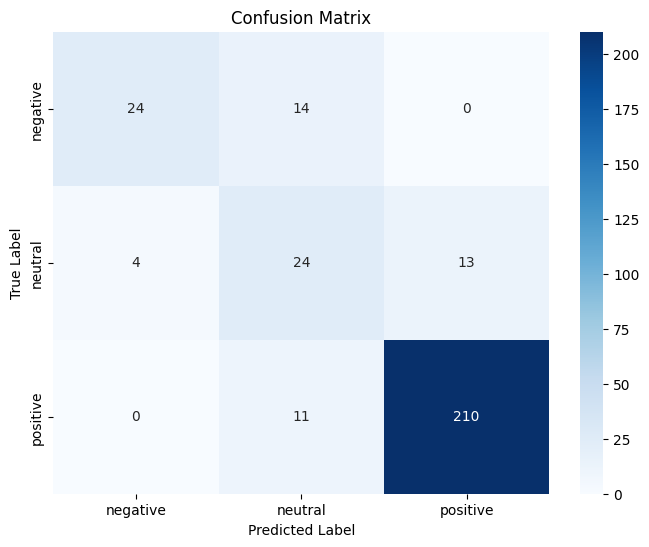

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from gensim.models import KeyedVectors
import re
import nltk
# from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive to access files
# drive.mount('/content/drive')

# Load dataset
# data_path = '/content/drive/My Drive/experiment/trip-advisor-copy.csv'
data_path = '/kaggle/input/tripadvisor-1000-dataset-examples/trip-advisor-copy.csv'
data = pd.read_csv(data_path)

# Preprocessing: Text Cleaning, Tokenization, and Normalization
nltk.download('punkt')

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

data['Cleaned_Review'] = data['Review'].apply(clean_text)

# Adjust labels for sentiment analysis
data['Sentiment'] = pd.cut(data['Rating'], bins=[-np.inf, 2, 3, np.inf], labels=['negative', 'neutral', 'positive'], right=False)

# Split data into train and test sets (70% train, 30% test)
train_texts, test_texts, train_labels, test_labels = train_test_split(data['Cleaned_Review'], data['Sentiment'], test_size=0.3, random_state=42)

# Load FastText model
fasttext_model_path = '/kaggle/input/fasttext-wikinews/wiki-news-300d-1M.vec'
fasttext_vectors = KeyedVectors.load_word2vec_format(fasttext_model_path, binary=False)

def text_to_vector(text):
    tokens = nltk.word_tokenize(text.lower())
    vectors = [fasttext_vectors[word] for word in tokens if word in fasttext_vectors]
    return np.mean(vectors, axis=0) if vectors else np.zeros(300)

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.linear = nn.Linear(300, 768)
        self.dropout = nn.Dropout(p=0.3)
        self.classifier = nn.Linear(768 * 2, n_classes)  # Combine BERT and FastText embeddings

    def forward(self, input_ids, attention_mask, fasttext_embeddings):
        # BERT
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_outputs.pooler_output

        # FastText
        fasttext_embeddings = self.linear(fasttext_embeddings)
        fasttext_embeddings = self.dropout(fasttext_embeddings)

        # Combine BERT and FastText embeddings
        combined = torch.cat((pooled_output, fasttext_embeddings), dim=1)
        output = self.classifier(combined)
        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentClassifier(len(data['Sentiment'].unique()))
model = model.to(device)

class ReviewDataset(Dataset):
    def __init__(self, reviews, ratings):
        self.reviews = reviews
        self.ratings = ratings
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews.iloc[idx]
        rating = self.ratings.iloc[idx]
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=512,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        fasttext_vector = torch.tensor(text_to_vector(review), dtype=torch.float)

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'fasttext_embeddings': fasttext_vector,
            'labels': torch.tensor(0 if rating == 'negative' else 1 if rating == 'neutral' else 2, dtype=torch.long)
        }

def create_data_loader(reviews, ratings, batch_size):
    ds = ReviewDataset(reviews, ratings)
    return DataLoader(ds, batch_size=batch_size, num_workers=2)

BATCH_SIZE = 8
train_data_loader = create_data_loader(train_texts, train_labels, BATCH_SIZE)
test_data_loader = create_data_loader(test_texts, test_labels, BATCH_SIZE)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss().to(device)

# Training loop
EPOCHS = 10

def train_epoch(model, data_loader, loss_fn, optimizer, device, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        fasttext_embeddings = d["fasttext_embeddings"].to(device)
        labels = d["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, fasttext_embeddings=fasttext_embeddings)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

# Main training loop with epoch print statements
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        len(train_texts)
    )

    print(f'Epoch {epoch + 1}/{EPOCHS}, Loss: {train_loss}, Accuracy: {train_acc}')

def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            fasttext_embeddings = d["fasttext_embeddings"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, fasttext_embeddings=fasttext_embeddings)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            real_values.extend(labels)

    return torch.stack(predictions).cpu(), torch.stack(real_values).cpu()

y_pred, y_true = get_predictions(model, test_data_loader)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive'])
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Confusion Matrix Visualization
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(conf_matrix, ['negative', 'neutral', 'positive'])
